# 1. Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Utilities and plotting
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Pre-processing
import nltk
import re
from nltk.corpus import stopwords
# nltk.download('wordnet')
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# Gensim
import gensim
from gensim.utils import simple_preprocess

# ANN
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Flatten, TimeDistributed

# Model checking
from sklearn.metrics import confusion_matrix,roc_curve,classification_report,auc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

C:\Users\bensj\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\bensj\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


# 2. Exploratory Data Analytics

In [2]:
data = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

In [3]:
data.columns = ['idx','clothingID','age','title','reviewText','rating','recommendedIND',
                'positiveFeedbackCount','divisionName','departmentName','className']

In [4]:
data.head()

,idx,clothingID,age,title,reviewText,rating,recommendedIND,positiveFeedbackCount,divisionName,departmentName,className
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
data.describe()

,idx,clothingID,age,rating,recommendedIND,positiveFeedbackCount
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


In [6]:
data.isnull().any()

idx                      False
clothingID               False
age                      False
title                     True
reviewText                True
rating                   False
recommendedIND           False
positiveFeedbackCount    False
divisionName              True
departmentName            True
className                 True
dtype: bool

In [7]:
data= data.fillna("")

In [8]:
data.isnull().any()

idx                      False
clothingID               False
age                      False
title                    False
reviewText               False
rating                   False
recommendedIND           False
positiveFeedbackCount    False
divisionName             False
departmentName           False
className                False
dtype: bool

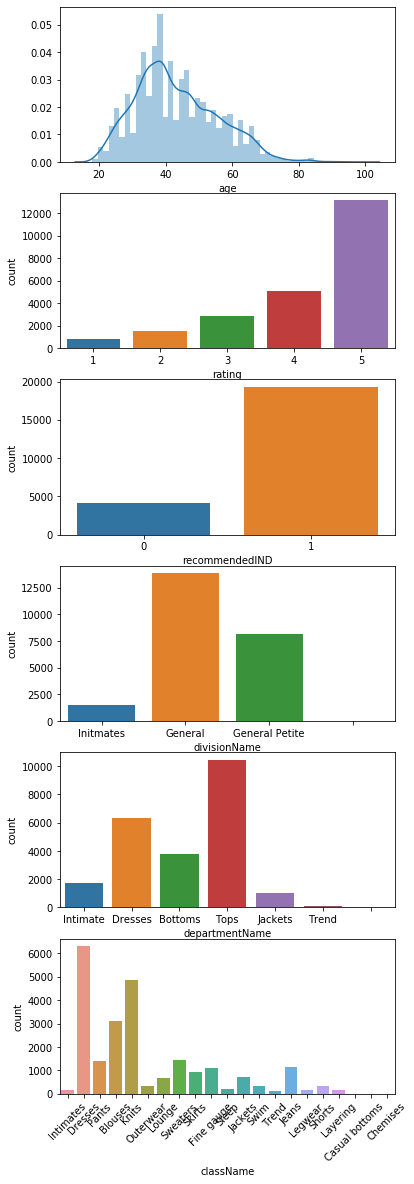

In [9]:
variables_barplot = ['age','rating','recommendedIND','divisionName','departmentName','className']
n=len(variables_barplot)
fig,ax = plt.subplots(6,1, figsize=(6,20))
for i in range(n):
    if variables_barplot[i] == "className":
        plt.sca(ax[i])
        chart = sns.countplot(x = variables_barplot[i], data = data)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    elif variables_barplot[i] == "age":
        plt.sca(ax[i])
        sns.distplot(data.age)
    else:
        plt.sca(ax[i])
        sns.countplot(x = variables_barplot[i], data = data)

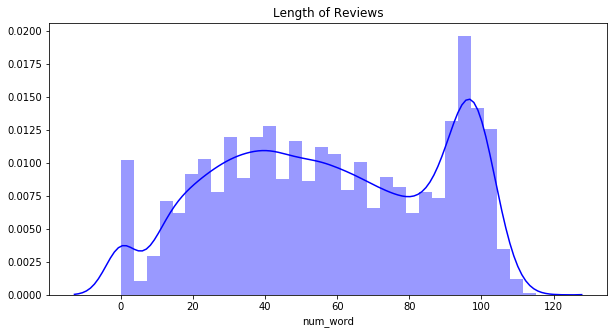

In [10]:
data['num_word'] = data.reviewText.apply(lambda x: len(x.split()))
fig = plt.figure(figsize=(10, 5))
#ax1 = plt.hist(df['Review Length'], color = "red", bins = 20)
ax = sns.distplot(data['num_word'], color="blue")
ax = plt.title("Length of Reviews")

# 3. Data Pre-processing

In [11]:
def pre_process(review):
    # Remove punctuations
    review = re.sub(r'[^\w\s]','',str(review))
    
    #Tokenize + lower case +deaccent
    review = gensim.utils.simple_preprocess(str(review), deacc=True)
    
    # Remove stop words
    stop_words = stopwords.words('english')
    review = [word for word in review if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    review = [lemmatizer.lemmatize(word,pos='v') for word in review]
    
    return (review," ".join(review))

In [12]:
data["review"] = data.reviewText.apply(lambda x: pre_process(x)[1])
data["review_list"] = data.reviewText.apply(lambda x: pre_process(x)[0]) # To find the max review length

In [13]:
data.head()

,idx,clothingID,age,title,reviewText,rating,recommendedIND,positiveFeedbackCount,divisionName,departmentName,className,num_word,review,review_list
0,0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,8,absolutely wonderful silky sexy comfortable,"[absolutely, wonderful, silky, sexy, comfortable]"
1,1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,62,love dress sooo pretty happen find store im gl...,"[love, dress, sooo, pretty, happen, find, stor..."
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,98,high hop dress really want work initially orde...,"[high, hop, dress, really, want, work, initial..."
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,22,love love love jumpsuit fun flirty fabulous ev...,"[love, love, love, jumpsuit, fun, flirty, fabu..."
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,36,shirt flatter due adjustable front tie perfect...,"[shirt, flatter, due, adjustable, front, tie, ..."


In [14]:
# Find the max review length
list_of_reviews = list(data.review) #Corpus
max_review_length = max([len(rev) for rev in data.review_list])

# Instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(data['review'])
vocab_size = count_matrix.get_shape()[1]
print("Shape of count_matrix (after vectorizing): ", count_matrix.get_shape())
print()

# Train-test split
features = count_matrix
response = data['recommendedIND']
x_train, x_test, y_train, y_test = train_test_split(features, response, test_size=0.30, random_state=4221)

# Oversampling minority class
sm = SMOTE(random_state=4221)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

# Condensing the array
x_train_res = list(map(lambda x: np.nonzero(x)[0],x_train_res.toarray()))
x_test = list(map(lambda x: np.nonzero(x)[0],x_test.toarray()))

# Padding
padded_x_train_res = pad_sequences(x_train_res, maxlen=max_review_length)
padded_x_test = pad_sequences(x_test, maxlen=max_review_length)

print("Before oversampling: " ,pd.Series(y_train).value_counts())
print()
print("After oversampling: " ,pd.Series(y_train_res).value_counts())

Shape of count_matrix (after vectorizing):  (23486, 15156)

Before oversampling:  1    13512
0     2928
Name: recommendedIND, dtype: int64

After oversampling:  1    13512
0    13512
dtype: int64


# 4. Recommender System

## 4.1. Similarity Matrix

Computing the Cosine Similarity of the text reviews

In [15]:
# Generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [16]:
# Create a dictionary to identify the Clothing ID based on the index
clothing_map = dict()
id_map = dict()

for index, row in data.iterrows():
    clothing_map[index] = row['clothingID']
    id_map[row['clothingID']] = index

## 4.2. Recommender Function

Done by selected the top 10 clothings with reviews most similar to the target clothing.

In [17]:
# Creating a Series for the movie titles so they are associated to an ordered numerical
# list we will use in the function to match the indexes
indices = pd.Series(data.idx)

#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def recommendations(clothing_id, cosine_sim = cosine_sim):
    clothing_idx = id_map[clothing_id]
    
    # initializing the empty list of recommended movies
    recommended_clothing = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == clothing_idx].index[0]
    #print(idx)

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    #print(top_10_indexes)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_clothing.append(clothing_map[i])
    print('The recommended clothings are: ')
    return recommended_clothing

In [18]:
# Example
recommendations(1077)

The recommended clothings are: 


[1094, 1087, 1093, 1100, 1078, 1072, 1022, 1077, 1078, 1092]

# 5. Words That Predict a "recommend"/"no recommend"

## 5.1. Sentiment Analyser
Determine if a review is positive or negative

In [19]:
# Defining a sentiment analyser function
def sentiment_analyser(text):
    return text.apply(lambda Text: pd.Series(TextBlob(Text).sentiment.polarity))

# Applying function to reviews
data['Polarity'] = sentiment_analyser(data['review'])

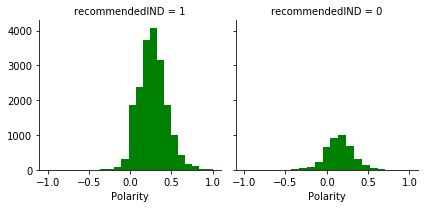

In [20]:
# Visualising polarity between recommending and non-recommending customers, then getting value counts
g = sns.FacetGrid(data, col="recommendedIND", col_order=[1, 0])
g = g.map(plt.hist, "Polarity", bins=20, color="g")

## 5.2. Generating text matrix

In [21]:
# Getting a count of words from the documents
# Ngram_range is set to 1,2 - this means that only one or two word combinations will be extracted
cvec = CountVectorizer(min_df=.005, max_df=.9, ngram_range=(1,2), tokenizer=lambda doc: doc, lowercase=False)
cvec.fit(data['review_list'])

# Creating the bag-of-words representation
cvec_counts = cvec.transform(data['review_list'])

# Instantiating the TfidfTransformer
transformer = TfidfTransformer()

# Fitting and transforming n-grams
transformed_weights = transformer.fit_transform(cvec_counts)

# Getting a list of all n-grams
transformed_weights = transformed_weights.toarray()
vocab = cvec.get_feature_names()

# Putting weighted n-grams into a DataFrame and computing some summary statistics
text_matrix = pd.DataFrame(transformed_weights, columns=vocab)
text_matrix.head(5)

,able,absolutely,absolutely love,across,actually,add,addition,adorable,adore,ago,...,xxs,year,years,yellow,yes,yesterday,yet,youre,zip,zipper
0,0.0,0.384864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171401,0.158332
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


## 5.3. Build Random Forest
We will be making use of the feature importance values provided by our random forest

In [22]:
X = text_matrix
y = data.recommendedIND

# Create a train-test split of these variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=4221)

# Oversample
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
X_test_sm, y_test_sm = sm.fit_sample(X_test, y_test)

In [23]:
def model_rf(model, model_name, x_train_sm, y_train_sm, x_test_sm, y_test_sm):
    model.fit(x_train_sm, y_train_sm)
    print(model_name)
    acc = cross_val_score(model, X_train_sm, y_train_sm, scoring = "accuracy", cv = 5)
    predictions = cross_val_predict(model, X_train_sm, y_train_sm, cv = 5)
    print("Accuracy:", round(acc.mean(),3))
    cm = confusion_matrix(predictions, y_train_sm)
    print("Confusion Matrix:  \n", cm)
    print("                    Classification Report \n",classification_report(predictions, y_train_sm))

In [24]:
# 2. Random Forest Classifier
rf = RandomForestClassifier(n_estimators=50)
model_rf(rf, "Random Forest Classifier", X_train_sm, y_train_sm, X_test_sm, y_test_sm)

Random Forest Classifier
Accuracy: 0.925
Confusion Matrix:  
 [[12274   814]
 [ 1238 12698]]
                    Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.94      0.92     13088
           1       0.94      0.91      0.93     13936

    accuracy                           0.92     27024
   macro avg       0.92      0.92      0.92     27024
weighted avg       0.92      0.92      0.92     27024



## 5.4. Plot Feature Importance

In [25]:
# Creating a plot for feature importance
def importance_plotting(data,x,y,palette,title):
    sns.set(style="whitegrid")
    chart = sns.PairGrid(data, y_vars=y, x_vars=x, height=5, aspect=1)
    chart.map(sns.stripplot, orient='h', palette=palette, edgecolor="black", size=15)
    for ax, titles in zip(chart.axes.flat, title):
        # Set a different title for each axes
        ax.set(title=titles)
        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
    plt.show()

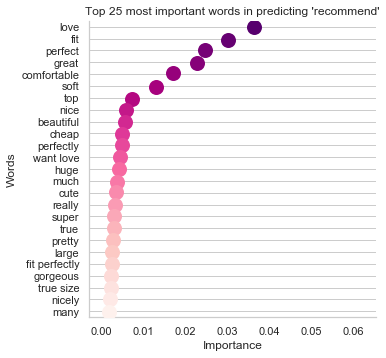

In [26]:
# Compile arrays of columns (words) and feature importances
feat_impt = {'Words':X.columns.tolist(),'Importance':rf.feature_importances_}

# Bung these into a dataframe, rank highest to lowest then slice top 25
Importance = pd.DataFrame(feat_impt,index=None).sort_values('Importance',ascending=False)
Importance['Polarity'] = sentiment_analyser(Importance['Words'])

# Positive polarity and plot
Importance_positive = Importance[Importance.Polarity > 0]
titles_positive = ["Top 25 most important words in predicting 'recommend'"]
importance_plotting(Importance_positive.head(25),'Importance','Words','RdPu_r',titles_positive)

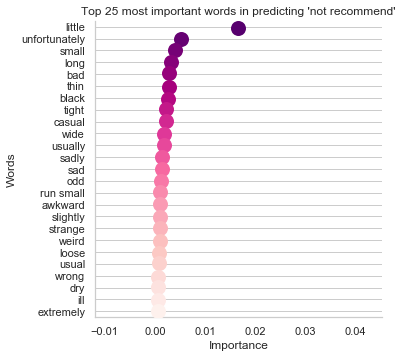

In [27]:
# Negative polarity and plot
Importance_negative = Importance[Importance.Polarity<0]
titles_negative = ["Top 25 most important words in predicting 'not recommend'"]
importance_plotting(Importance_negative.head(25),'Importance','Words','RdPu_r',titles_negative)

# 6. Building a Model to Predict Recommendation

## 6.1. Model Building

In [28]:
def build_model(Optimizer,x_train,y_train,x_test,y_test):
    
    # Initialising NN
    model = Sequential()
    
    # Embedding requires that the input data be integer encoded, so that each word is represented by a unique integer
    # input_dim = vocab size (max number of words)
    # input length = length of each input (we set padding to be max_review_length)
    model.add(Embedding(input_dim = vocab_size, output_dim = 128, input_length=max_review_length))
   
    # We are implementing a bidirectional LSTM from keras
    # Dropout is set to 0.5 to account for overfitting
    # Merge mode is set to concat as it is emperically proved to provide better results (refer to link 5 in References)
    model.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.50),merge_mode='concat'))
    
    # Time distributed dense layer ensures that our dense layer are independent. Different layers from different
    # timestamp will not interact with each other. relu activation to avoid underfitting (refer to link 7 in references)
    model.add(TimeDistributed(Dense(128,activation='relu')))
    
    # Flatten our NN for the next dense layer
    model.add(Flatten())
    
    # Add one more dense layer
    model.add(Dense(128,activation='relu'))
    
    # We are adding a dense layer to ensure that the output ranges from 0 and 1.
    model.add(Dense(1, activation='sigmoid'))    
    
    # loss function used is binary crossentropy as our output is binary
    # Used RMSProp as it is shown to provide great results by decreasing the step for large gradient to avoid exploding,
    # and increase the step for small gradient to avoid vanishing (refer to link 6 in References)
    model.compile(loss='binary_crossentropy', optimizer = Optimizer, metrics=['accuracy'])
    scores = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))
    return scores, model

# 6.2. Model validation

In [29]:
# Train Model
score, model = build_model('RMSprop',padded_x_train_res,y_train_res,padded_x_test,y_test)

C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy

C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy

C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy

C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy

C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy

C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy

C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy

C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy

C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\bensj\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy

Train on 27024 samples, validate on 7046 samples
Epoch 1/10
27024/27024 [==============================] - 155s 6ms/step - loss: 0.3486 - acc: 0.8413 - val_loss: 0.5394 - val_acc: 0.7607
Epoch 2/10
27024/27024 [==============================] - 154s 6ms/step - loss: 0.2213 - acc: 0.9129 - val_loss: 0.3228 - val_acc: 0.8613
Epoch 3/10
27024/27024 [==============================] - 155s 6ms/step - loss: 0.1833 - acc: 0.9308 - val_loss: 0.4175 - val_acc: 0.8794
Epoch 4/10
27024/27024 [==============================] - 155s 6ms/step - loss: 0.1570 - acc: 0.9399 - val_loss: 0.3829 - val_acc: 0.8696
Epoch 5/10
27024/27024 [==============================] - 154s 6ms/step - loss: 0.1313 - acc: 0.9508 - val_loss: 0.4424 - val_acc: 0.8538
Epoch 6/10
27024/27024 [==============================] - 495s 18ms/step - loss: 0.1110 - acc: 0.9580 - val_loss: 0.7065 - val_acc: 0.8690
Epoch 7/10
27024/27024 [==============================] - 164s 6ms/step - loss: 0.0941 - acc: 0.9639 - val_loss: 0.6040 - 

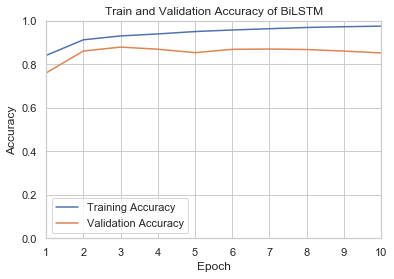

In [30]:
# Validation accuracy per epoch by plotting.
plt.plot(range(1,11), score.history['acc'], label='Training Accuracy') 
plt.plot(range(1,11), score.history['val_acc'], label='Validation Accuracy')
plt.axis([1, 10, 0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy of BiLSTM')
plt.legend()
plt.show()

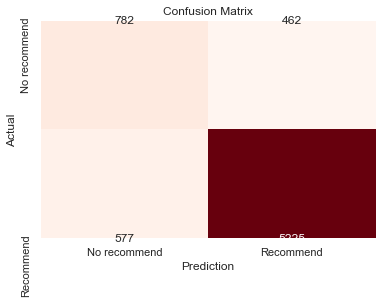

In [31]:
# Plot confusion matrix
y_test_pred = model.predict_classes(padded_x_test) 
c_matrix = confusion_matrix(y_test, y_test_pred)
ax= plt.subplot()
sns.heatmap(c_matrix, annot=True, xticklabels= ['No recommend', 'Recommend'], yticklabels=['No recommend', 'Recommend'], cbar=False, cmap='Reds', fmt='g')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

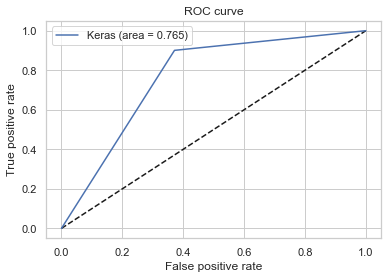

In [32]:
# ROC and AUC
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_test_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# References:
Data: https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews
1. https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456
2. BiLSTM: https://towardsdatascience.com/sentence-classification-using-bi-lstm-b74151ffa565
3. BiLSTM explained: https://stackoverflow.com/questions/43035827/whats-the-difference-between-a-bidirectional-lstm-and-an-lstm
4. SMOTE explained: http://rikunert.com/SMOTE_explained
5. BiLSTM  concat: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
6. Why RMSProp: https://medium.com/100-days-of-algorithms/day-69-rmsprop-7a88d475003b
7. Why timedistributed: https://datascience.stackexchange.com/questions/10836/the-difference-between-dense-and-timedistributeddense-of-keras
8. Words prediction: https://www.kaggle.com/josh24990/nlp-ml-which-words-predict-a-recommendation